## Setup

In [3]:
!pip install --upgrade google_play_scraper

In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

In [5]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'
app_packages = [
    'com.amazon.mShop.android.shopping']

## Scraping App Information

In [6]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='uk') # from the UK markert
    del info['comments']
    app_infos.append(info)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Let's look at the corresponding JSON objects:

In [7]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [6]:
print_json(app_infos[0])

{
  "adSupported": true,
  "androidVersion": "8.0",
  "androidVersionText": "8.0 and up",
  "appId": "com.amazon.mShop.android.shopping",
  "containsAds": true,
  "contentRating": "Parental guidance",
  "contentRatingDescription": "Parental Guidance Recommended",
  "currency": "GBP",
  "description": "<h2><b>Product Features</b></h2>\r\nAmazon Shopping offers app-only benefits to help make shopping on Amazon faster and easier than shopping on your desktop.\r\n\r\n<h2><b>Never miss a delivery</b></h2>\r\nGet real-time tracking and delivery notifications so you know where your package is and when it arrives. \r\n\r\n<h2><b>Know exactly what you\u2019re purchasing</b></h2>\r\nFull 360\u00b0 product view lets you see items from every angle. \u201cView in you room\u201d makes sure it fits by using your phone\u2019s camera and VR so you can see it in your space. \r\n\r\n<h2><b>We\u2019ll notify you when items go on sale</b></h2>\r\nJust tap the heart icon to save items to Your Lists and we\u

## Print Logos

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

(-0.5, 511.5, 511.5, -0.5)

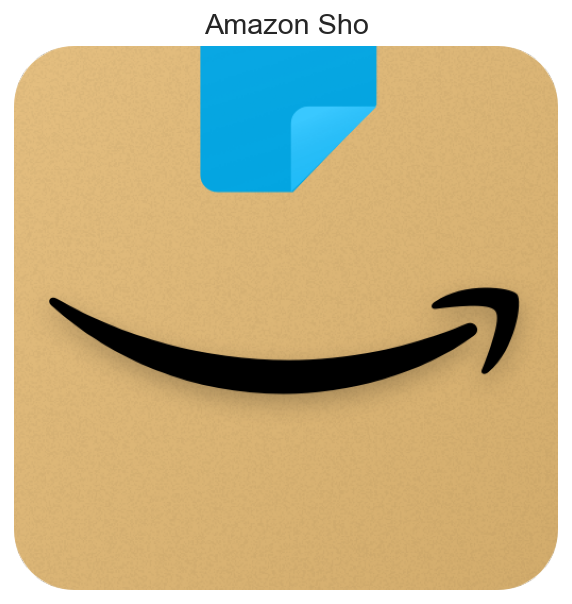

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, ax = plt.subplots(1, len(app_infos) // 1, figsize=(14, 5))

ai = app_infos[0]
img = plt.imread(ai['icon'])
ax.imshow(img)
ax.set_title(format_title(ai['title']))
ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [8]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('./apps.csv', index=None, header=True)

In [9]:
app_infos_df.head()

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,...,released,updated,version,recentChanges,recentChangesHTML,editorsChoice,similarApps,moreByDeveloper,appId,url
0,Amazon Shopping,<h2><b>Product Features</b></h2>\r\nAmazon Sho...,<h2><b>Product Features</b></h2><br>Amazon Sho...,"Browse, search & buy millions of products righ...","Browse, search &amp; buy millions of products ...","500,000,000+",500000000,4.324227,2752527,31556,...,"Dec 10, 2014",1647381273,24.6.0.100,Access popular pages quickly with our new shor...,Access popular pages quickly with our new shor...,False,"[com.contextlogic.wish, com.ebay.mobile, com.a...","[com.amazon.dee.app, com.amazon.avod.thirdpart...",com.amazon.mShop.android.shopping,https://play.google.com/store/apps/details?id=...


## Scraping App Reviews

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

 ``google_play_scraper.reviews``.

In [10]:
result, continuation_token = reviews(
    'com.fantome.penguinisle',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=1, # defaults to 100
    filter_score_with=5 # defaults to None(means all score)
)
result

[{'reviewId': 'gp:AOqpTOGFqKBAWOLF90XJm3ztJkT0EED3MA3xi8oW3DmGmgF_rc1oNmn8D8dAFQ8s_uj4YD46gKd8e0LwD2Ghu7I',
  'userName': 'Kailey Reyés',
  'userImage': 'https://play-lh.googleusercontent.com/a-/AOh14Gi8aw8-6SkhWmcWeogrZ5TI3JS1Kd3JfMCa8FVHMgc',
  'content': "This game is amazing! Everytime I click on to get a bonus or more coins to watch an ad, it's doesn't give me any ads, it just gives me the bonus or the coins!! Definitely one of my favorite games on the app store! It's calming and cute! I love unlocking creature and adding furniture and new islands!! It's so cute! I love this game! It gives me happy feet vibes! The penguins are so adorable too!! It kept me hooked for hours! 🔥",
  'score': 5,
  'thumbsUpCount': 0,
  'reviewCreatedVersion': '1.44.0',
  'at': datetime.datetime(2022, 3, 28, 23, 37, 1),
  'replyContent': None,
  'repliedAt': None}]

In [11]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='uk',
                sort=sort_order,
                count= 2000 if score == 3 else 2050,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:11<00:00, 71.46s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [12]:
print_json(app_reviews[0])

{
  "appId": "com.amazon.mShop.android.shopping",
  "at": "2022-03-31 14:12:15",
  "content": "Problems with app. If you selext the user icon at the bottom and click on Your Orders, nothing shows. App fully updated and clearing app cache don't change a thing. Android 12, samsung One UI 4.0. Still waiting for Amazon to fix this app.",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "24.6.0.100",
  "reviewId": "gp:AOqpTOF5GJG3P-a0gIKoyrf6c69V9vYoABkx3QDk-STVbySWZa-3TOPL46WEnUPB5YeBrEcUc-KWzeuxWOp3Mg",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 2,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14GjCBgeSCHBS-3TBnedudBbeI2uqpjNmGhpLc491zy4",
  "userName": "Ousmane Sokona"
}



In [13]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  10200  reviews


In [14]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('./amazonreviews3.csv', index=None, header=True)

In [2]:
# importing packages for analysing reviews
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

import nltk
from nltk.stem import *
from nltk.stem.porter import *

In [3]:
file = open('amazonreviews3.csv', encoding='utf-8')
app_reviews = pd.read_csv(file)
app_reviews_df = pd.DataFrame(app_reviews)

In [4]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOF5GJG3P-a0gIKoyrf6c69V9vYoABkx3QDk-ST...,Ousmane Sokona,https://play-lh.googleusercontent.com/a-/AOh14...,Problems with app. If you selext the user icon...,1,2,24.6.0.100,2022-03-31 14:12:15,NaN,NaN,newest,com.amazon.mShop.android.shopping
1,gp:AOqpTOFjqwC3nveYFl_WUFnR4GQY0_Y-nSzyjhQJfKn...,Regiogaming -,https://play-lh.googleusercontent.com/a-/AOh14...,i can't even open the app. I'm in Indonesia re...,1,0,24.6.0.100,2022-03-31 13:52:36,NaN,NaN,newest,com.amazon.mShop.android.shopping
2,gp:AOqpTOGRoEQSgmf_9tIr-fmclM8St2wGBuHZF-6ENG2...,Amy Thompson,https://play-lh.googleusercontent.com/a-/AOh14...,Amazon lies about free shipping hoping u won't...,1,1,24.5.2.100,2022-03-31 13:28:54,NaN,NaN,newest,com.amazon.mShop.android.shopping
3,gp:AOqpTOFkyjZnen0V2-CDiczrcRbSc1f0aw1Et63oe2i...,Demetrius Collins,https://play-lh.googleusercontent.com/a-/AOh14...,Probably one of the worst shopping apps I've e...,1,0,24.6.0.100,2022-03-31 12:33:24,NaN,NaN,newest,com.amazon.mShop.android.shopping
4,gp:AOqpTOEhNd4W7f-P9R0Z_LaosKMavgl2eDK9SXBEAxJ...,Mahmoud Emam,https://play-lh.googleusercontent.com/a/AATXAJ...,لا يوجد مصداقية طلبت شاشة وانتظرت اسبوع وبعدين...,1,0,24.6.0.100,2022-03-31 12:14:20,NaN,NaN,newest,com.amazon.mShop.android.shopping


In [5]:
set(app_reviews_df['appId'])

{'com.amazon.mShop.android.shopping'}

In [6]:
amazon_reviews_df = app_reviews_df.loc[app_reviews_df['appId'] == "com.amazon.mShop.android.shopping"]
len(amazon_reviews_df)

10200

In [7]:
amazon_reviews = amazon_reviews_df['content']
amazon_reviews.head()

0    Problems with app. If you selext the user icon...
1    i can't even open the app. I'm in Indonesia re...
2    Amazon lies about free shipping hoping u won't...
3    Probably one of the worst shopping apps I've e...
4    لا يوجد مصداقية طلبت شاشة وانتظرت اسبوع وبعدين...
Name: content, dtype: object

In [8]:
review_list = []
for i in range(len(amazon_reviews)):
    review_list.append(str(amazon_reviews[i]))
review_string = str(".".join(review_list))
#review_string

### Pre-processing and Explatory Analysis

In [15]:
import nltk
import numpy
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
#nltk.download('punkt')

In [16]:
review_tokens = word_tokenize(review_string)
review_tokens = [word.lower() for word in review_tokens]

In [17]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BUSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Not removing stopwords now as they may be effective in sentence level scoring

In [18]:
edited_punctuation = list(string.punctuation)
remove = ['!']
edited_punctuation = [word 
                 for word in list(string.punctuation) 
                 if not word in remove]

In [19]:
numbers_1_to_100 = [str(integer) for integer in range(101)]
extra_punctuation_to_remove = ['.', '..','...','....','.....','......', ').', '.,']
individual_letters = list(string.ascii_lowercase)

[('the', 7980), ('to', 7867), ('it', 5530), ('and', 5337), ('app', 3442), ('is', 3316), ('my', 3101), ("n't", 2948), ('!', 2666), ('for', 2602), ('amazon', 2324), ('you', 2222), ('of', 2190), ('on', 2184), ('not', 1987), ('but', 1941), ('in', 1862), ('have', 1844), ('this', 1788), ("'s", 1731), ('that', 1671), ('with', 1381), ('they', 1353), ('do', 1338), ('me', 1325), ('so', 1176), ('when', 1118), ('be', 1034), ('get', 1016), ('or', 983)]


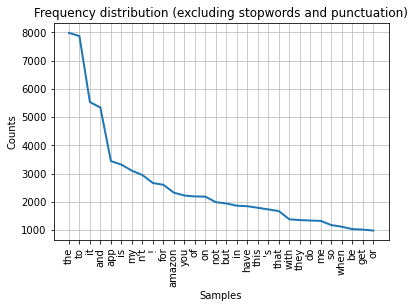

<AxesSubplot:title={'center':'Frequency distribution (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [20]:
remove_these =  list(edited_punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters 

filtered_text = [word 
                 for word in review_tokens 
                 if not word in remove_these]

fdist_filtered = FreqDist(filtered_text)
print(fdist_filtered.most_common(30))
fdist_filtered.plot(30,title='Frequency distribution (excluding stopwords and punctuation)')

In [21]:
print( [word for (word,count) in fdist_filtered.most_common(150)])

['the', 'to', 'it', 'and', 'app', 'is', 'my', "n't", '!', 'for', 'amazon', 'you', 'of', 'on', 'not', 'but', 'in', 'have', 'this', "'s", 'that', 'with', 'they', 'do', 'me', 'so', 'when', 'be', 'get', 'or', 'was', 'are', 'just', 'can', 'no', 'from', 'all', 'ca', 'now', 'like', 'time', 'up', 'your', 'if', 'at', 'use', 'what', 'as', 'an', 'has', 'good', 'order', 'very', 'items', "'m", 'prime', 'out', 'does', 'been', 'service', 'orders', 'delivery', 'back', 'there', 'love', 'update', 'even', 'shopping', 'will', 'would', 'customer', 'great', 'then', 'phone', 'had', 'account', 'more', 'because', 'find', 'want', 'one', 'please', 'only', 'need', 'never', 'see', 'go', 'fix', 'item', 'why', '``', 'search', 'other', 'really', "''", 'still', 'things', 'something', 'some', "'ve", 'way', 'work', 'them', 'new', 'how', 'money', 'did', 'day', 'about', 'slow', 'than', 'always', 'am', 'its', 'after', 'buy', 'keeps', 'used', 'wo', 'their', 'know', 'much', 'page', 'products', 'easy', 'times', 'every', 'by',

In [22]:
some_more_words_to_remove = ['.-', '.,', ',,', "'s", 'ca', '."', 'one', 'per', "''", '``', "'m", "'ve", 'also', "'re", 'wo', '.i', '--']

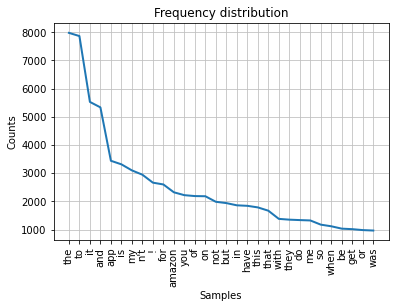

<AxesSubplot:title={'center':'Frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [23]:
filtered_text = [word 
                 for word in filtered_text 
                 if not word in some_more_words_to_remove]

fdist_filtered = FreqDist(filtered_text)
fdist_filtered.plot(30,title='Frequency distribution')

In [24]:
print( [word for (word,count) in fdist_filtered.most_common(150)])

['the', 'to', 'it', 'and', 'app', 'is', 'my', "n't", '!', 'for', 'amazon', 'you', 'of', 'on', 'not', 'but', 'in', 'have', 'this', 'that', 'with', 'they', 'do', 'me', 'so', 'when', 'be', 'get', 'or', 'was', 'are', 'just', 'can', 'no', 'from', 'all', 'now', 'like', 'time', 'up', 'your', 'if', 'at', 'use', 'what', 'as', 'an', 'has', 'good', 'order', 'very', 'items', 'prime', 'out', 'does', 'been', 'service', 'orders', 'delivery', 'back', 'there', 'love', 'update', 'even', 'shopping', 'will', 'would', 'customer', 'great', 'then', 'phone', 'had', 'account', 'more', 'because', 'find', 'want', 'please', 'only', 'need', 'never', 'see', 'go', 'fix', 'item', 'why', 'search', 'other', 'really', 'still', 'things', 'something', 'some', 'way', 'work', 'them', 'new', 'how', 'money', 'did', 'day', 'about', 'slow', 'than', 'always', 'am', 'its', 'after', 'buy', 'keeps', 'used', 'their', 'know', 'much', 'page', 'products', 'easy', 'times', 'every', 'by', 'through', 'shipping', 'any', 'product', 'load', 

In [25]:
# filter adjectives and make fdist graph
import nltk
nltk.download('tagsets')
from nltk.tag import pos_tag
nltk.help.upenn_tagset('JJ')
nltk.help.upenn_tagset('JJR')
nltk.help.upenn_tagset('JJS')

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
JJR: adjective, comparative
    bleaker braver breezier briefer brighter brisker broader bumper busier
    calmer cheaper choosier cleaner clearer closer colder commoner costlier
    cozier creamier crunchier cuter ...
JJS: adjective, superlative
    calmest cheapest choicest classiest cleanest clearest closest commonest
    corniest costliest crassest creepiest crudest cutest darkest deadliest
    dearest deepest densest dinkiest ...


[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\BUSE\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [26]:
tagged_text = nltk.pos_tag(filtered_text)
pos_tags = ['JJ', 'JJR', 'JJS']
adjectives = [word for (word, pos) in tagged_text if pos in pos_tags]
fdist_filtered = FreqDist(adjectives)
print( [word for (word,count) in fdist_filtered.most_common(20)])

['good', 'prime', 'great', 'amazon', 'app', 'other', 'new', 'more', 'easy', 'many', 'last', 'slow', 'same', 'bad', 'wrong', 'update', 'few', 'much', 'able', 'better']


In [27]:
to_remove = ['app', 'amazon', 'fix', 'prime', 'update', 'many', 'much', 'alexa', 'lot', 'screen', 'give', 'navigate', 'need', 'click', 'wish', 'delete', 'android']
filtered_adj = [word 
                 for word in adjectives
                 if not word in to_remove]

fdist_filtered = FreqDist(filtered_adj)
print( [word for (word,count) in fdist_filtered.most_common(20)])

['good', 'great', 'other', 'new', 'more', 'easy', 'last', 'slow', 'same', 'bad', 'wrong', 'few', 'able', 'better', 'best', 'dark', 'different', 'fine', 'difficult', 'most']


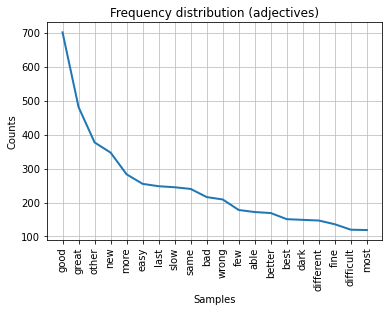

<AxesSubplot:title={'center':'Frequency distribution (adjectives)'}, xlabel='Samples', ylabel='Counts'>

In [28]:
fdist_filtered.plot(20,title='Frequency distribution (adjectives)')

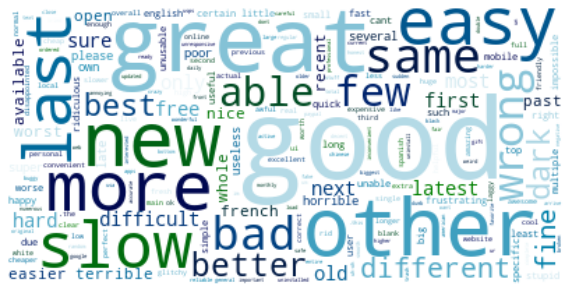

In [29]:
# make a word cloud
# Adjectives
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

simple_frequencies_dict = Counter(filtered_adj)

cloud = WordCloud(max_font_size=80,colormap="ocean",background_color='white').generate_from_frequencies(simple_frequencies_dict)
plt.figure(figsize=(10,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive views such as "good", "great", and "easy" seem to have dominant frequency however, the words "slow","bad" and "wrong" follow them closely.

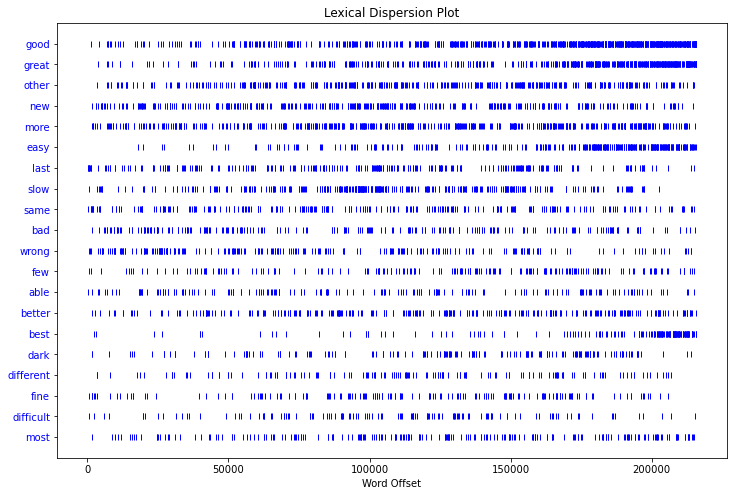

In [30]:
# lexical dispersion for adjectives
from nltk.draw.dispersion import dispersion_plot

plt.figure(figsize=(12, 8))
targets=[word for (word,count) in fdist_filtered.most_common(20)]

dispersion_plot(filtered_text, targets, ignore_case=True, title='Lexical Dispersion Plot')

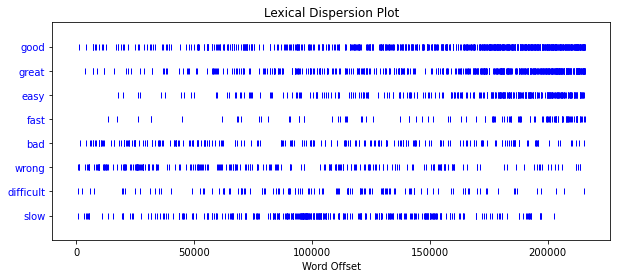

In [31]:
from nltk.draw.dispersion import dispersion_plot

plt.figure(figsize=(10, 4))
targets=['good', 'great', 'easy', 'fast','bad', 'wrong', 'difficult', 'slow']

dispersion_plot(filtered_text, targets, ignore_case=True, title='Lexical Dispersion Plot')

Looking at the data, it starts with the most recent comments and gets older ones as it proceeds, this means the postive comments with positive adjectives are more frequent in old comments and negative feedbacks are more recent.

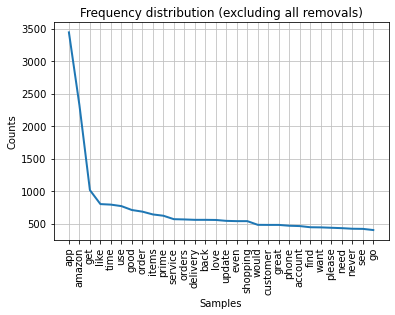

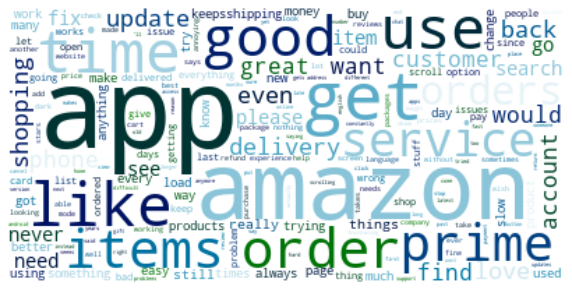

In [32]:
# A word cloud for full reviews with further cleansing
some_words_to_remove = ['.-', '.,', ',,', "'s", 'ca', '."', 'one', 'per', "''", '``', "'m", "'ve", 'also', "'re", 'wo', '.i', '--', "n't"]
remove_all = list(set(stopwords.words('english'))) + list(string.punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters + some_words_to_remove 

filtered_text_new = [word 
                 for word in review_tokens 
                 if not word in remove_all]

fdist_filtered = FreqDist(filtered_text_new)
fdist_filtered.plot(30,title='Frequency distribution (excluding all removals)')
simple_frequencies_dict = Counter(filtered_text_new)

cloud = WordCloud(max_font_size=80,colormap="ocean",background_color='white').generate_from_frequencies(simple_frequencies_dict)
plt.figure(figsize=(10,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

'good', 'like' and 'love' are some positive highlights where 'app', 'delivery', 'order', 'orders', 'service' are likely to give hints about quality issues.

In [33]:
# Analysing bigrams
from nltk.tokenize import TweetTokenizer # using tweet tokenizer to avoid splits of "can't, doesn't etc."
tt = TweetTokenizer()
review_tokens_b = tt.tokenize(review_string)
remove_these = list(set(stopwords.words('english'))) + list(string.punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters + some_words_to_remove 

review_tokens_b = [word 
                 for word in review_tokens_b 
                 if not word in remove_these]

words = [w for w in review_tokens_b]

all_grams = nltk.FreqDist(w for w in nltk.bigrams(review_tokens_b))
all_grams

FreqDist({('I', "can't"): 385, ('I', 'love'): 291, ('customer', 'service'): 274, ('app', 'I'): 231, ('I', 'want'): 202, ('The', 'app'): 179, ('I', 'get'): 175, ('I', 'like'): 173, ('time', 'I'): 160, ('I', 'need'): 159, ...})

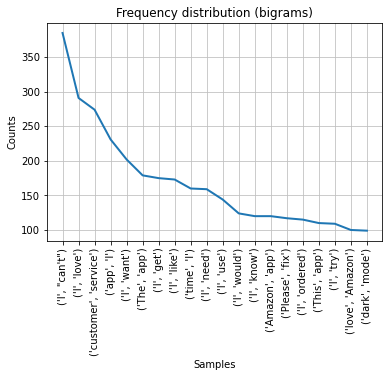

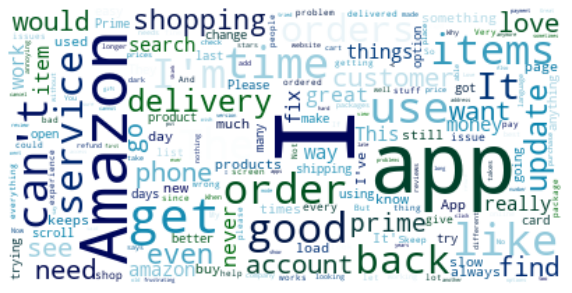

In [34]:
fdist_filtered = all_grams
fdist_filtered.plot(20,title='Frequency distribution (bigrams)')
simple_frequencies_dict = Counter(review_tokens_b)

cloud = WordCloud(max_font_size=80,colormap="ocean",background_color='white').generate_from_frequencies(simple_frequencies_dict)
plt.figure(figsize=(10,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

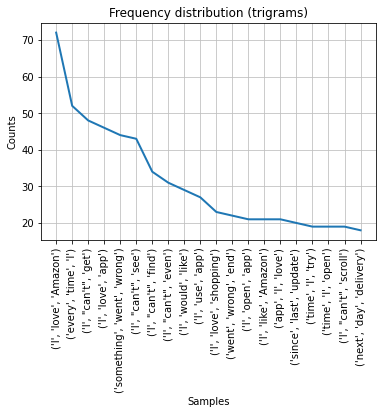

<AxesSubplot:title={'center':'Frequency distribution (trigrams)'}, xlabel='Samples', ylabel='Counts'>

In [35]:
# Analysing trigrams
from nltk.util import trigrams
tri_grams = nltk.FreqDist(w for w in nltk.trigrams(review_tokens_b))

fdist_filtered = tri_grams
fdist_filtered.plot(20,title='Frequency distribution (trigrams)')

### Sentiment Analysis (Sentence Level)

In [36]:
amazon_reviews.head()

0    Problems with app. If you selext the user icon...
1    i can't even open the app. I'm in Indonesia re...
2    Amazon lies about free shipping hoping u won't...
3    Probably one of the worst shopping apps I've e...
4    لا يوجد مصداقية طلبت شاشة وانتظرت اسبوع وبعدين...
Name: content, dtype: object

In [37]:
# separate sentences of reviews - moving on with original data (no removed words or puncts) for sentence level labelling
from nltk import tokenize

sen_tokentized_revs = []
for i in range(len(amazon_reviews)):
    sen_tokentized_revs.append(tokenize.sent_tokenize(str(amazon_reviews[i])))

In [38]:
sen_tokentized_revs[0]

['Problems with app.',
 'If you selext the user icon at the bottom and click on Your Orders, nothing shows.',
 "App fully updated and clearing app cache don't change a thing.",
 'Android 12, samsung One UI 4.0.',
 'Still waiting for Amazon to fix this app.']

In [39]:
num_sen = []
for rev in sen_tokentized_revs:
    num_sen.append(len(rev))
    
avg_num_sentences = sum(num_sen)/len(num_sen)
round(avg_num_sentences,2)

2.01

In [40]:
# Labelling with Vader, also loading other packages for sentiment analysis for possible future use
nltk.download('sentiwordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\BUSE\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\BUSE\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [41]:
# Create a sentiment intensity analyzer object:
sid = SIA()

# Recording review labels and scores as lists
rev_label = []
rev_score = []

# Looping reviews and reviews' sentences
for rev in sen_tokentized_revs:
    sen_score = []
    for sentence in rev:
        ss = sid.polarity_scores(sentence) 
        sen_score.append(round(ss['compound'],3))
    rev_score.append(round(sum(sen_score)/len(rev),3))
    if round(sum(sen_score)/len(rev),3) < 0:
        rev_label.append('negative')
    elif round(sum(sen_score)/len(rev),3) == 0:
        rev_label.append('neutral')
    else:
        rev_label.append('positive')

In [42]:
rev_label[0:5]

['negative', 'neutral', 'positive', 'negative', 'neutral']

In [43]:
rev_score[0:5]

[-0.045, 0.0, 0.331, -0.625, 0.0]

In [44]:
# Quantified labels for possible future use
rev_numeric_label = []
for label in rev_score:
    if label < 0:
        rev_numeric_label.append(-1)
    elif label == 0:
        rev_numeric_label.append(0)
    else:
        rev_numeric_label.append(1)

rev_numeric_label[0:5]

[-1, 0, 1, -1, 0]

In [45]:
# Merge reviews with scores and labels in a dataframe
reviews_df = pd.DataFrame(list(zip(amazon_reviews, rev_score, rev_label, rev_numeric_label)),
              columns=['review','score', 'label', 'label_n'])
reviews_df.head()

,review,score,label,label_n
0,Problems with app. If you selext the user icon...,-0.045,negative,-1
1,i can't even open the app. I'm in Indonesia re...,0.000,neutral,0
2,Amazon lies about free shipping hoping u won't...,0.331,positive,1
3,Probably one of the worst shopping apps I've e...,-0.625,negative,-1
4,لا يوجد مصداقية طلبت شاشة وانتظرت اسبوع وبعدين...,0.000,neutral,0


In [46]:
set(reviews_df['label'])

{'negative', 'neutral', 'positive'}

In [47]:
# Basic descriptive insight on positive and negative reviews
reviews_df = reviews_df.loc[reviews_df['label'] != 'neutral']
print('Total reviews: ', len(reviews_df))

pos_reviews = reviews_df.loc[reviews_df['label'] =='positive']
print('Positive reviews: ', len(pos_reviews), '%',round(len(pos_reviews)/len(reviews_df),2)*100)

neg_reviews = reviews_df.loc[reviews_df['label'] =='negative']
print('Negative reviews: ', len(neg_reviews), '%',round(len(neg_reviews)/len(reviews_df),2)*100)

Total reviews:  8100
Positive reviews:  5124 % 63.0
Negative reviews:  2976 % 37.0


In [48]:
# Checking the number of pos and neg reviews over time
import datetime
from datetime import datetime,date
reviews_df['date'] = app_reviews['at']
reviews_df['date'] = pd.to_datetime(reviews_df['date']).dt.date # to avoid timestamp
reviews_df = reviews_df.reset_index(drop=True)
reviews_df.head()

,review,score,label,label_n,date
0,Problems with app. If you selext the user icon...,-0.045,negative,-1,2022-03-31
1,Amazon lies about free shipping hoping u won't...,0.331,positive,1,2022-03-31
2,Probably one of the worst shopping apps I've e...,-0.625,negative,-1,2022-03-31
3,Since last update I cannot see my orders...ver...,-0.440,negative,-1,2022-03-31
4,I didn't get a package from Amazon and they ne...,0.599,positive,1,2022-03-31


In [49]:
df = reviews_df.drop(columns = ['review', 'score', 'label_n'])

In [50]:
# date positive negative
positive = []
negative = []
for i in range(len(df)):
    if df['label'][i] == 'positive':
        positive.append(1)
        negative.append(0)
    else:
        positive.append(0)
        negative.append(1)
        
df = df.drop(columns = 'label')
df['positive'] = positive
df['negative'] = negative
df.head()

,date,positive,negative
0,2022-03-31,0,1
1,2022-03-31,1,0
2,2022-03-31,0,1
3,2022-03-31,0,1
4,2022-03-31,1,0


In [51]:
df1 = df.drop(columns = 'positive')
df1 = df1.groupby(['date']).sum()

df2 = df.drop(columns = 'negative')
df2 = df2.groupby(['date']).sum()

df1['positive'] = df2['positive']
df1.sort_values(by='date', ascending = False, inplace=True)
df1 = df1.reset_index(level=0)
df1.head()

,date,negative,positive
0,2022-03-31,19,30
1,2022-03-30,40,68
2,2022-03-29,24,62
3,2022-03-28,33,65
4,2022-03-27,32,50


In [52]:
#groupby mm-yyyy format for visualisation
for d in range(len(df1['date'])):
    df1['date'][d] = df1['date'][d].strftime('%Y-%m')
df1 = df1.groupby(['date']).sum()
df1 = df1.reset_index(level=0)
df1.head()

<ipython-input-52-aadcfcd0850a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'][d] = df1['date'][d].strftime('%Y-%m')


,date,negative,positive
0,2021-08,31,34
1,2021-09,182,364
2,2021-10,361,492
3,2021-11,290,393
4,2021-12,300,489


<AxesSubplot:title={'center':'Reviews Per Date'}, xlabel='Date', ylabel='Number of Reviews'>

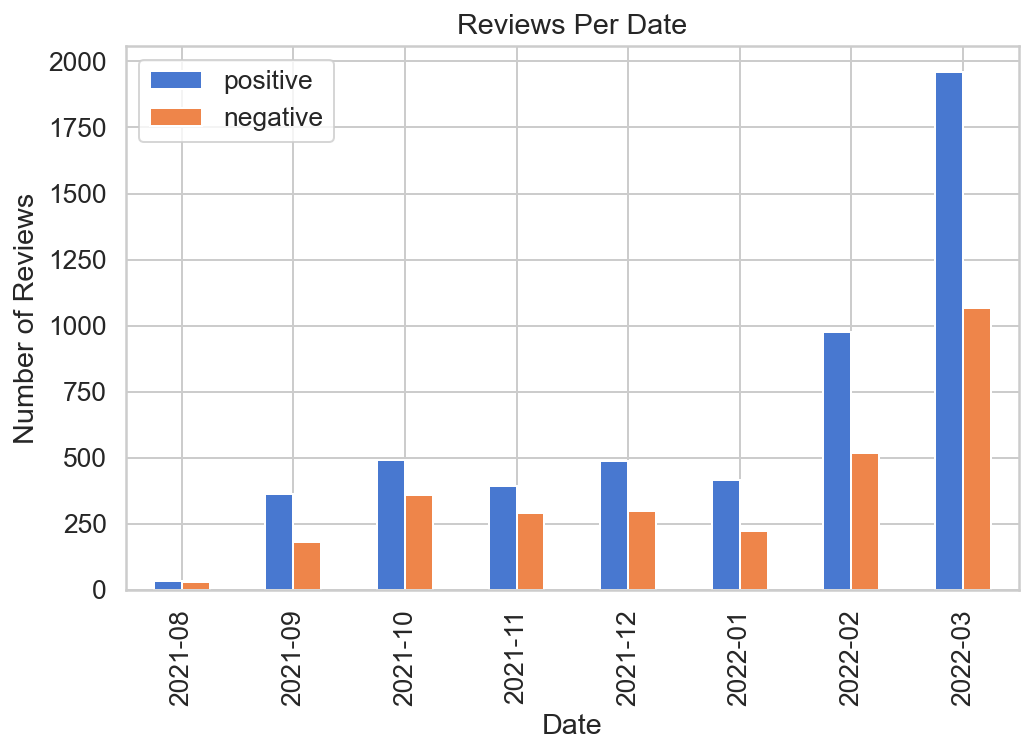

In [60]:
df1.plot(title='Reviews Per Date', x='date', y=["positive", "negative"], kind = "bar", xlabel = 'Date', ylabel = 'Number of Reviews', figsize = (8,5))

In [53]:
df1['pos%'] = round(df1['positive']/(df1['positive']+df1['negative'])*100,2)
df1['neg%'] = round(df1['negative']/(df1['positive']+df1['negative'])*100,2)
df1.head()

,date,negative,positive,pos%,neg%
0,2021-08,31,34,52.31,47.69
1,2021-09,182,364,66.67,33.33
2,2021-10,361,492,57.68,42.32
3,2021-11,290,393,57.54,42.46
4,2021-12,300,489,61.98,38.02


<AxesSubplot:title={'center':'Reviews Per Date'}, xlabel='Date', ylabel='% Reviews'>

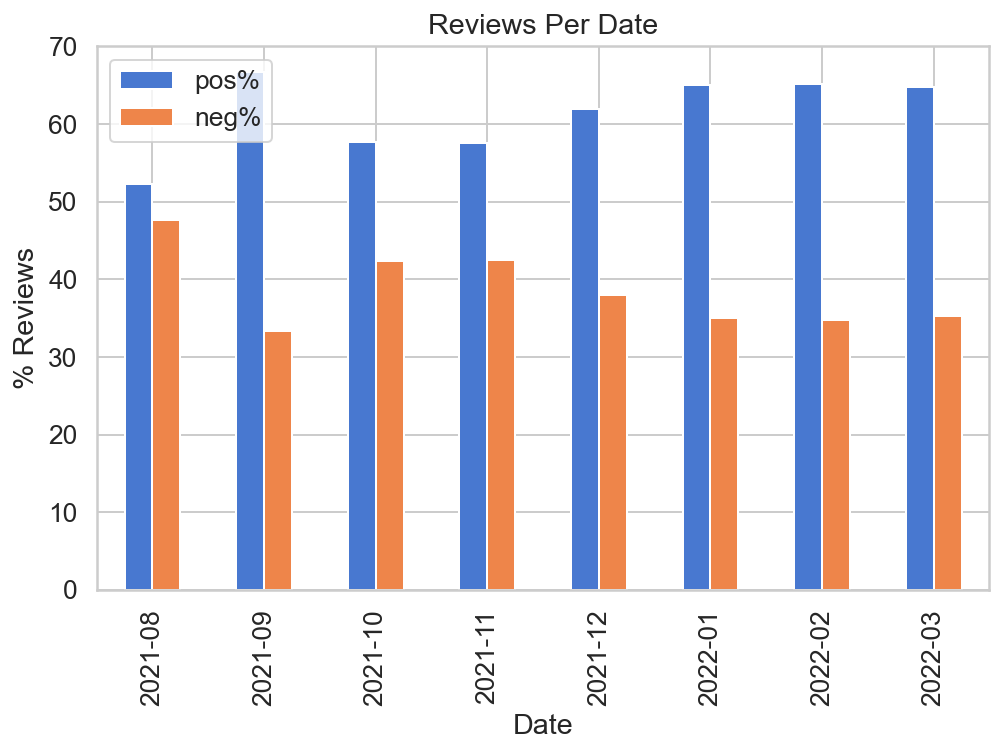

In [62]:
df1.plot(title='Reviews Per Date', x='date', y=["pos%", "neg%"], kind = "bar", xlabel = 'Date', ylabel = '% Reviews', figsize = (8,5))

In [54]:
# Focusing on negative reviews for insights on quality issues
neg_reviews = reviews_df.loc[reviews_df['label'] =='negative']
neg_reviews = neg_reviews.reset_index(drop=True)
neg_reviews.head()

,review,score,label,label_n,date
0,Problems with app. If you selext the user icon...,-0.045,negative,-1,2022-03-31
1,Probably one of the worst shopping apps I've e...,-0.625,negative,-1,2022-03-31
2,Since last update I cannot see my orders...ver...,-0.440,negative,-1,2022-03-31
3,I dont understand how a HUGE company has the w...,-0.236,negative,-1,2022-03-31
4,After having my account for 13 years Amazon ba...,-0.051,negative,-1,2022-03-31


In [55]:
# word-bigram-trigram level analysis on negative reviews
neg_review_list = []
for i in range(len(neg_reviews)):
    neg_review_list.append(str(neg_reviews['review'][i]))
neg_review_string = str(".".join(neg_review_list))

import re
!pip install emoji
import emoji
def extract_emojis(my_tweets):
    emoji_list = [] 
    emoji_list.extend(''.join(e for e in my_tweets if e in emoji.UNICODE_EMOJI['en']))
    return emoji_list

tt = TweetTokenizer()
neg_tokens = tt.tokenize(neg_review_string)

remove_emojis = extract_emojis(neg_tokens)

some_words_to_remove = ['.-', '.,', ',,', "'s", 'ca', '."', 'one', 'per', "''", '``', "'m", "'ve", 'also', "'re", 'wo', '.i', '--', "n't", "I'm", "It", "It's", "it", "I've", "^", "I", "can't", "This", "even", "Amazon", "The", "So", "My", "No", "amazon"]
remove_these = list(set(stopwords.words('english'))) + list(string.punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters + some_words_to_remove + remove_emojis

neg_tokens_f = [word 
                 for word in neg_tokens 
                 if not word in remove_these]

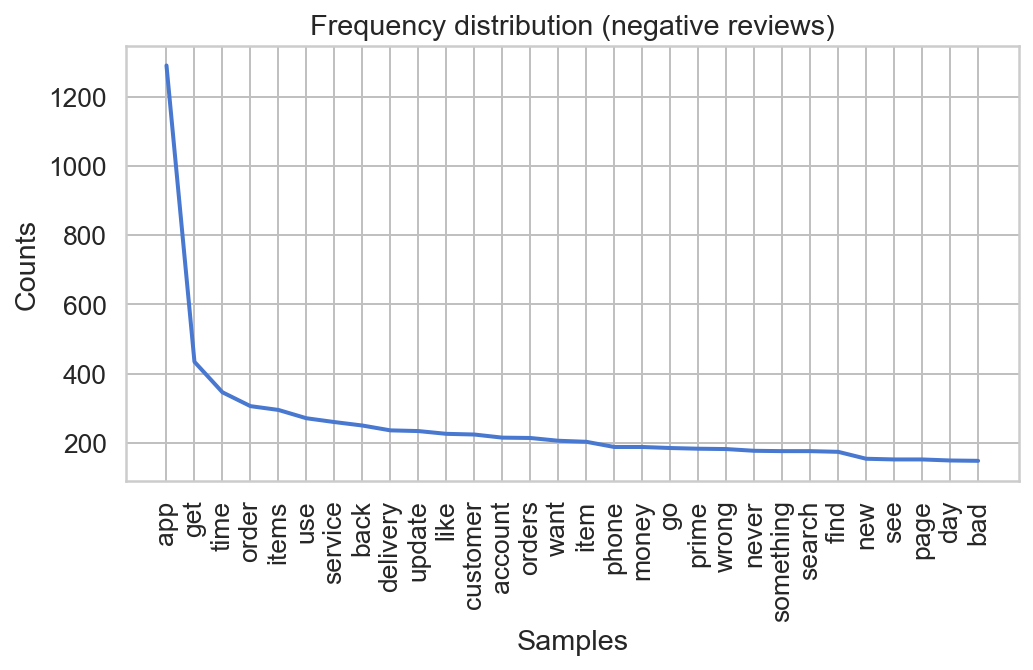

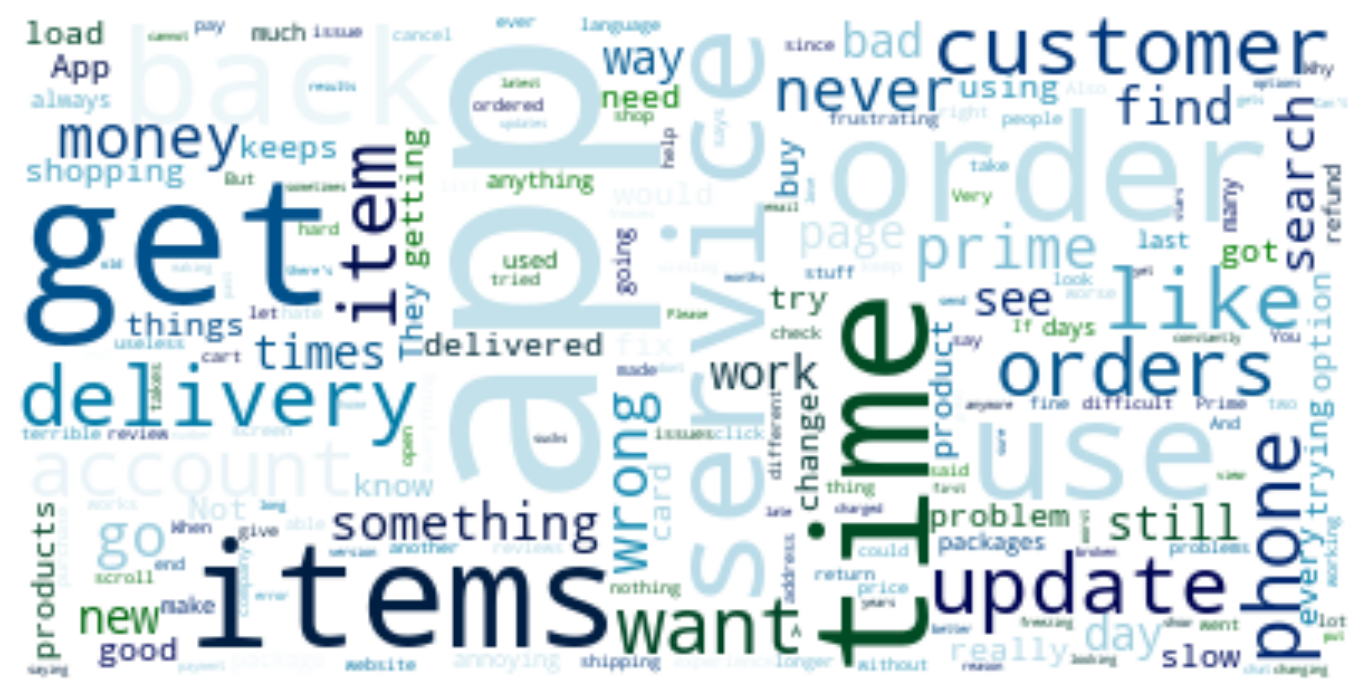

In [65]:
fdist_filtered = FreqDist(neg_tokens_f)
plt.figure(figsize=(8,4))
fdist_filtered.plot(30,title='Frequency distribution (negative reviews)')
simple_frequencies_dict = Counter(neg_tokens_f)

cloud = WordCloud(max_font_size=80,colormap="ocean",background_color='white').generate_from_frequencies(simple_frequencies_dict)
plt.figure(figsize=(12,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
# bigrams
some_words_to_remove = ['.-', '.,', ',,', "'s", 'ca', '."', 'one', 'per', "''", '``', "'m", "'ve", "'re", 'wo', '.i', '--', "n't", "^", "I", "The", "This", "I've", "I'm", "can't", "i'm"]
remove_these = list(set(stopwords.words('english'))) + list(string.punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters + some_words_to_remove + remove_emojis 

neg_tokens = [word.lower() for word in neg_tokens ]


neg_tokens_b = [word 
                 for word in neg_tokens 
                 if not word in remove_these]

words = [w for w in neg_tokens_b]

all_grams = nltk.FreqDist(w for w in nltk.bigrams(neg_tokens_b))
all_grams

FreqDist({('customer', 'service'): 179, ('every', 'time'): 60, ('went', 'wrong'): 59, ('something', 'went'): 57, ('amazon', 'app'): 49, ('amazon', 'prime'): 44, ('please', 'fix'): 41, ('app', 'keeps'): 37, ('dark', 'mode'): 36, ('last', 'update'): 35, ...})

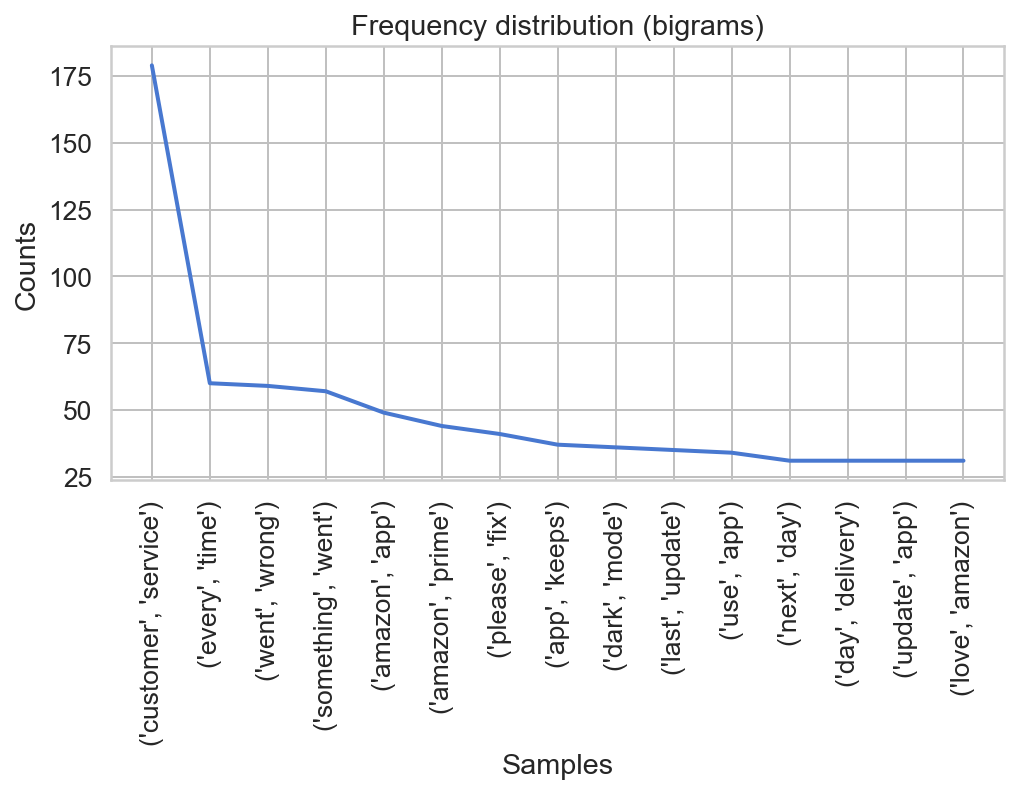

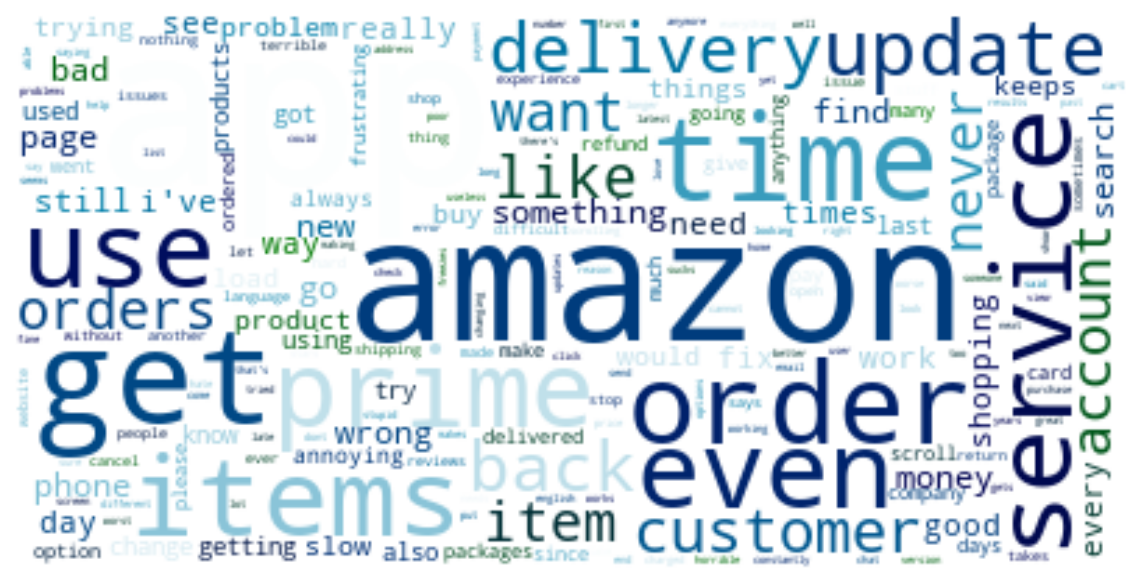

In [67]:
fdist_filtered = all_grams
plt.figure(figsize=(8,4))
fdist_filtered.plot(15,title='Frequency distribution (bigrams)')
simple_frequencies_dict = Counter(neg_tokens_b)

cloud = WordCloud(max_font_size=80,colormap="ocean",background_color='white').generate_from_frequencies(simple_frequencies_dict)
plt.figure(figsize=(10,6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Highlighted possible issues from bigrams are customer service contact, app crashes, dark mode and delivery day.

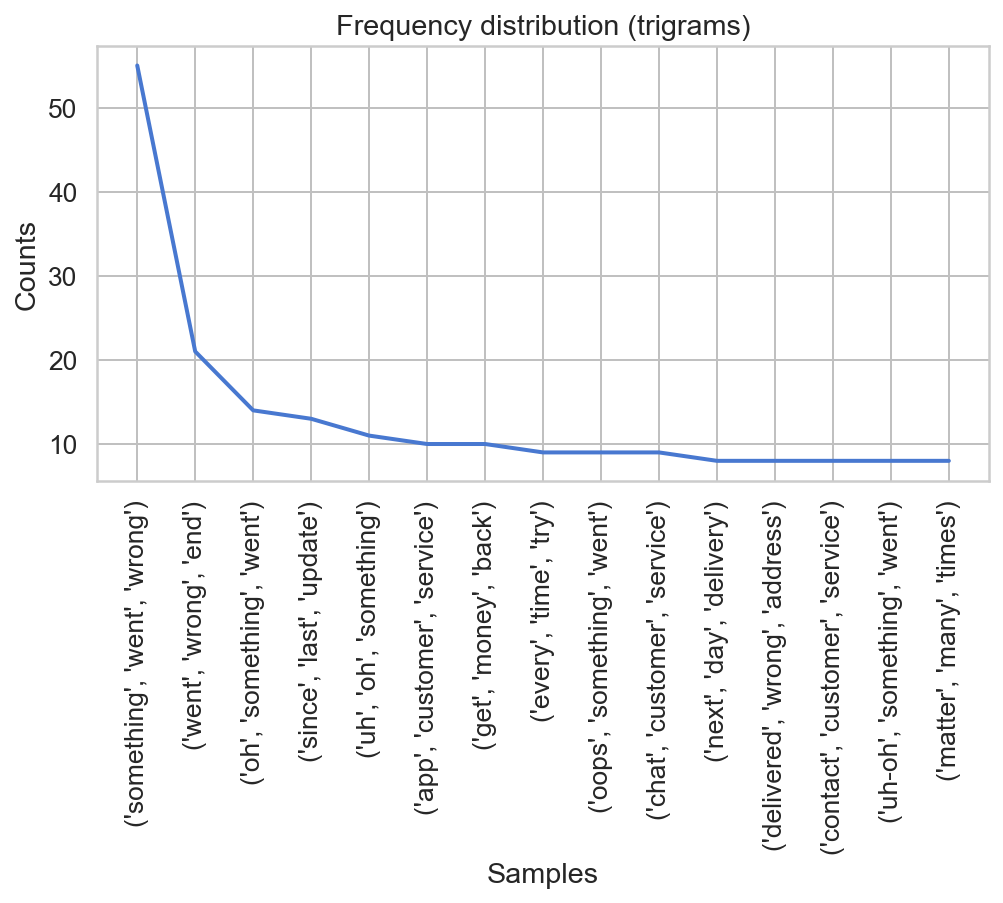

<AxesSubplot:title={'center':'Frequency distribution (trigrams)'}, xlabel='Samples', ylabel='Counts'>

In [68]:
# trigrams
from nltk.util import trigrams
tri_grams = nltk.FreqDist(w for w in nltk.trigrams(neg_tokens_b))

fdist_filtered = tri_grams
plt.figure(figsize=(8,4))
fdist_filtered.plot(15,title='Frequency distribution (trigrams)')

Frequency of "Something went wrong" error seems like the main problem for Amazon shopping app, app crashes must definitely be attended to.

Customer service contact, delivery to wrong address, refunds and untimely deliveries are the following issues to be solved.

In [127]:
print( [word for (word,count) in tri_grams.most_common(15)])
print(tri_grams[('something', 'went', 'wrong')])

[('something', 'went', 'wrong'), ('went', 'wrong', 'end'), ('oh', 'something', 'went'), ('since', 'last', 'update'), ('uh', 'oh', 'something'), ('app', 'customer', 'service'), ('get', 'money', 'back'), ('every', 'time', 'try'), ('oops', 'something', 'went'), ('chat', 'customer', 'service'), ('next', 'day', 'delivery'), ('delivered', 'wrong', 'address'), ('contact', 'customer', 'service'), ('uh-oh', 'something', 'went'), ('matter', 'many', 'times')]
55


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
# Topic Modeling
!pip install gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


some_words_to_remove = ['.-', '.,', ',,', "'s", 'ca', '."', 'one', 'per', "''", '``', "'m", "'ve", "'re", 'wo', '.i', '--', "n't", "^", "I", "The", "This", "I've", "I'm", "can't", "i'm", "amazon", 'like', 'get', 'even', 'would', 'many', 'iui', 'they', 'porque', 'naqel','use', 'err', 'zzz', 'di']
remove_these = list(set(stopwords.words('english'))) + list(string.punctuation) + list(string.digits) + numbers_1_to_100 + extra_punctuation_to_remove + individual_letters + some_words_to_remove 
stop_words = remove_these
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
import gensim
data = neg_reviews['review'].values.tolist()
data_words = list(sent_to_words(data)) 

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['problems', 'app', 'selext', 'user', 'icon', 'bottom', 'click', 'orders', 'nothing', 'shows', 'app', 'fully', 'updated', 'clearing', 'app', 'cache', 'change', 'thing', 'android', 'samsung', 'ui', 'still', 'waiting', 'fix', 'app']


In [98]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View example
print(corpus[:1][0][:30])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 4), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]


In [102]:
from pprint import pprint

# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the keywords in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.027*"app" + 0.012*"time" + 0.005*"wrong" + 0.005*"find" + 0.005*"want" + '
  '0.005*"never" + 0.005*"update" + 0.005*"load" + 0.005*"product" + '
  '0.005*"prime"'),
 (1,
  '0.037*"app" + 0.007*"prime" + 0.007*"order" + 0.006*"orders" + 0.006*"fix" '
  '+ 0.006*"something" + 0.006*"work" + 0.005*"update" + 0.005*"back" + '
  '0.005*"delivery"'),
 (2,
  '0.020*"app" + 0.010*"items" + 0.009*"order" + 0.008*"delivery" + '
  '0.008*"service" + 0.007*"money" + 0.006*"prime" + 0.006*"item" + '
  '0.006*"back" + 0.006*"never"'),
 (3,
  '0.028*"app" + 0.007*"service" + 0.007*"bad" + 0.006*"customer" + '
  '0.006*"time" + 0.005*"order" + 0.005*"update" + 0.004*"delivery" + '
  '0.004*"search" + 0.004*"way"')]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


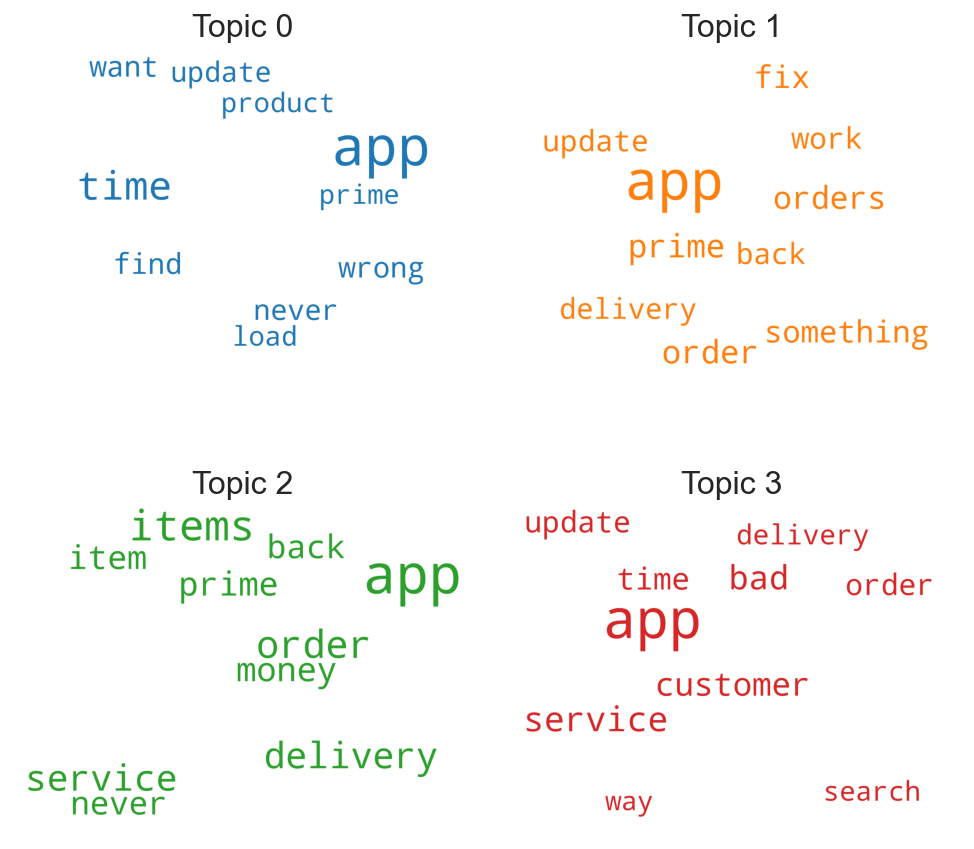

In [103]:
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [104]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.042786 -0.000369       1        1  30.943866
1     -0.029793  0.026744       2        1  28.494682
0     -0.019011 -0.038808       3        1  20.908531
3      0.006017  0.012433       4        1  19.652921, topic_info=          Term         Freq        Total Category  logprob  loglift
1          app  1314.000000  1314.000000  Default  30.0000  30.0000
71        time   320.000000   320.000000  Default  29.0000  29.0000
402        bad   167.000000   167.000000  Default  28.0000  28.0000
119     trying   114.000000   114.000000  Default  27.0000  27.0000
7          fix   135.000000   135.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
11      orders    31.318380   208.900994   Topic4  -5.6904  -0.2707
129        day    28.866683   143.665990   Topic4  -5.7720   0.0221
272       back    31.241685   238.093793   Topic4  -5.6929  -0.4040
115  something    29.142492   194.346328   Topic4  -5.7625  -0.2705
32         see    28.369482   138.273662   Topic4  -5.7893   0.0430

[354 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3546      2  0.730414  accessing
77        1  0.398280    account
77        2  0.263860    account
77        3  0.204118    account
77        4  0.134419    account
...     ...       ...        ...
343       2  0.161040  yesterday
5191      4  0.619554      zaggs
3088      1  0.711211        zar
3022      2  0.731514         zu
5872      4  0.827707        zzz

[716 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])